# Hi :)

----

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Loading the dataset

In [2]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.cifar10.load_data()

In [3]:
x_data= np.concatenate((x_train, x_test), axis= 0)
y_data= np.concatenate((y_train, y_test), axis= 0)

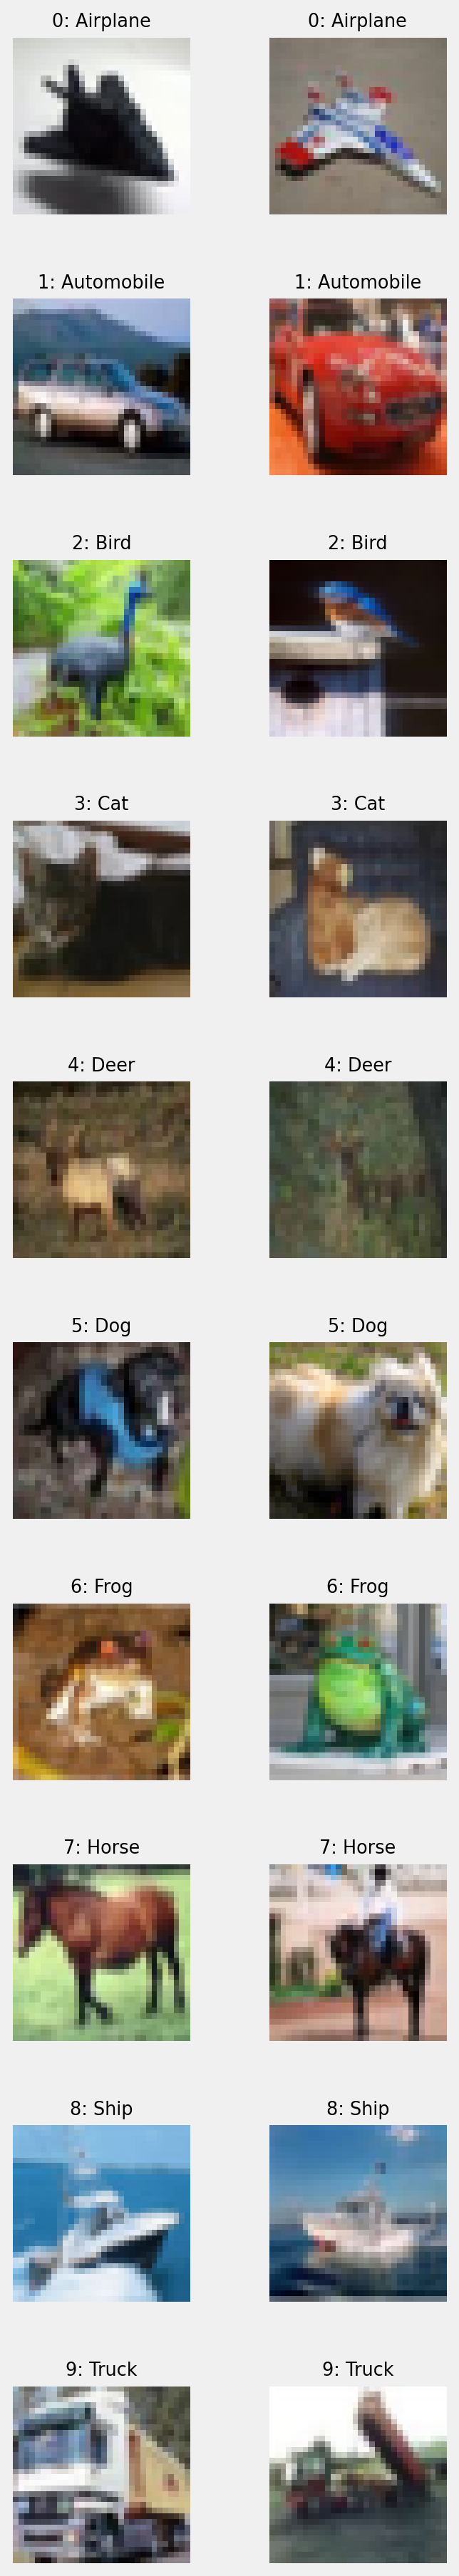

In [4]:
# CIFAR-10 class names
class_names= [
    "Airplane", "Automobile", "Bird", "Cat", 
    "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"
]

# Create a dictionary to store two examples for each class
examples= {class_id : [] for class_id in range(10)}

# Loop through the data and collect two examples per class
for i in range(len(y_data)):
    class_id= y_data[i][0]  # Extract class index
    if len(examples[class_id]) < 2:
        examples[class_id].append(x_data[i])
    if all(len(v) == 2 for v in examples.values()):  # Stop when all classes have 2 examples
        break

# Plot the examples
plt.style.use('fivethirtyeight')
fig, axes= plt.subplots(10, 2, figsize= (4, 20), dpi= 184)
fig.tight_layout(pad= 0.48)
for class_id, rows in examples.items():
    for j, img in enumerate(rows):
        ax= axes[class_id, j]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"{class_id}: {class_names[class_id]}", fontsize= 10)
plt.show()


In [5]:
all_samples= {class_id : [] for class_id in range(10)}
for i in range(len(y_data)):
    class_id= y_data[i][0]  # Extract class index
    all_samples[class_id].append(i)
df= pd.DataFrame(all_samples)
df.columns= class_names
df.head()

,Airplane,Automobile,Bird,Cat,Deer,Dog,Frog,Horse,Ship,Truck
0,29,4,6,9,3,27,0,7,8,1
1,30,5,13,17,10,40,19,11,62,2
2,35,32,18,21,20,51,22,12,69,14
3,49,44,24,26,28,56,23,37,92,15
4,77,45,41,33,34,70,25,43,100,16


In [6]:
df.isna().sum()

Airplane      0
Automobile    0
Bird          0
Cat           0
Deer          0
Dog           0
Frog          0
Horse         0
Ship          0
Truck         0
dtype: int64

In [7]:
df.shape

(6000, 10)

# Step 1

selecting 10,000 data(1,000 for eace class)

In [8]:
num_per_class= 1000
num_classes= 10

selected_images= []
selected_labels= []

for class_id in range(num_classes):
    class_indices= np.where(y_data == class_id)[0]
    selected_indices= np.random.choice(class_indices, num_per_class, replace= False)
    selected_images.append(x_data[selected_indices])
    selected_labels.append(y_data[selected_indices])

selected_images= np.concatenate(selected_images, axis= 0)
selected_labels= np.concatenate(selected_labels, axis= 0)

print(f"Selected images shape: {selected_images.shape}")
print(f"Selected labels shape: {selected_labels.shape}")

Selected images shape: (10000, 32, 32, 3)
Selected labels shape: (10000, 1)


# Step 2

set the resolutions(32x32 and 16x16)

In [9]:
original_resolution= (32, 32)
low_resolution= (16, 16)

data_high_res= x_data.copy()

data_low_res= []
for img in x_data:
    low_res_img= Image.fromarray(img).resize(low_resolution, Image.ANTIALIAS)
    data_low_res.append(np.array(low_res_img))
data_low_res= np.array(data_low_res)

print(f"High-resolution data shape: {data_high_res.shape}")
print(f"Low-resolution data shape: {data_low_res.shape}")

C:\Users\Erfaan_Joodi\AppData\Local\Temp\ipykernel_16820\3995905558.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  low_res_img= Image.fromarray(img).resize(low_resolution, Image.ANTIALIAS)


High-resolution data shape: (60000, 32, 32, 3)
Low-resolution data shape: (60000, 16, 16, 3)


# Step 3

spliting the dataset to train and test and validation

In [10]:
train_ratio= 0.7
val_ratio= 0.15
test_ratio= 0.15

num_samples= len(y_data)

indices= np.arange(num_samples)
np.random.shuffle(indices)

train_end= int(train_ratio * num_samples)
val_end= train_end + int(val_ratio * num_samples)

train_indices= indices[ : train_end]
val_indices= indices[train_end : val_end]
test_indices= indices[val_end : ]


x_train_high, x_val_high, x_test_high= data_high_res[train_indices], data_high_res[val_indices], data_high_res[test_indices]
x_train_low, x_val_low, x_test_low= data_low_res[train_indices], data_low_res[val_indices], data_low_res[test_indices]
y_train, y_val, y_test= y_data[train_indices], y_data[val_indices], y_data[test_indices]


print(f"High-Resolution Data Shapes: Train: {x_train_high.shape}, Validation: {x_val_high.shape}, Test: {x_test_high.shape}")
print(f"Low-Resolution Data Shapes: Train: {x_train_low.shape}, Validation: {x_val_low.shape}, Test: {x_test_low.shape}")
print(f"Labels Shapes: Train: {y_train.shape}, Validation: {y_val.shape}, Test: {y_test.shape}")

High-Resolution Data Shapes: Train: (42000, 32, 32, 3), Validation: (9000, 32, 32, 3), Test: (9000, 32, 32, 3)
Low-Resolution Data Shapes: Train: (42000, 16, 16, 3), Validation: (9000, 16, 16, 3), Test: (9000, 16, 16, 3)
Labels Shapes: Train: (42000, 1), Validation: (9000, 1), Test: (9000, 1)


# Step 4

creating the CNN model

high resolution

In [11]:
def create_high_res_cnn_model():
    model= models.Sequential([
        # first layer
        layers.Conv2D(32, (3, 3), activation= 'relu', padding= 'same', input_shape= (32, 32, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # second layer
        layers.Conv2D(64, (3, 3), activation= 'relu', padding= 'same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # third layer
        layers.Conv2D(128, (3, 3), activation= 'relu', padding= 'same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # flatting and danse layers
        layers.Flatten(),
        layers.Dense(128, activation= 'relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation= 'softmax')  # 10 class output
    ])
    return model

high_res_cnn_model= create_high_res_cnn_model()

high_res_cnn_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001),  # optimizer and learning rate
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),     # loss function
    metrics= ['accuracy']                                      # accuracy
)

high_res_cnn_model.summary()

f:\Quera\Qvenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,706 (1.36 MB)

 Trainable params: 357,258 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

low resolution

In [12]:
def create_low_res_cnn_model():
    model= models.Sequential([
        # first layer
        layers.Conv2D(32, (3, 3), activation= 'relu', padding= 'same', input_shape= (16, 16, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # second layer
        layers.Conv2D(64, (3, 3), activation= 'relu', padding= 'same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # third layer
        layers.Conv2D(128, (3, 3), activation= 'relu', padding= 'same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # flatting and danse layers
        layers.Flatten(),
        layers.Dense(128, activation= 'relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation= 'softmax') # 10 class output
    ])
    return model

low_res_cnn_model= create_low_res_cnn_model()

low_res_cnn_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001),  # optimizer and learning rate
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),     # loss function
    metrics= ['accuracy']                                      # accuracy
)

low_res_cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,098 (629.29 KB)

 Trainable params: 160,650 (627.54 KB)

 Non-trainable params: 448 (1.75 KB)

# Step 5

learning rate and optimizer

high resolution

In [13]:
high_res_cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,706 (1.36 MB)

 Trainable params: 357,258 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

low resolution

In [14]:
low_res_cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,098 (629.29 KB)

 Trainable params: 160,650 (627.54 KB)

 Non-trainable params: 448 (1.75 KB)

# Step 6

learning

high resolution

In [15]:
#normalization
x_train_high= x_train_high / 255.0
x_val_high= x_val_high / 255.0
x_test_high= x_test_high / 255.0

print("Training on high-resolution data...")
history_high= high_res_cnn_model.fit(
    x_train_high, y_train,
    validation_data= (x_val_high, y_val),
    epochs= 10,
    batch_size= 64
)

print("\nEvaluating on high-resolution test data...")
test_loss_high, test_acc_high= high_res_cnn_model.evaluate(x_test_high, y_test)
print(f"Test Accuracy (High-Resolution): {test_acc_high:.4f}")

Training on high-resolution data...
Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 123s 141ms/step - accuracy: 0.3340 - loss: 1.9361 - val_accuracy: 0.5250 - val_loss: 1.3063
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 92s 140ms/step - accuracy: 0.5058 - loss: 1.3597 - val_accuracy: 0.4728 - val_loss: 1.5927
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 92s 139ms/step - accuracy: 0.5771 - loss: 1.1737 - val_accuracy: 0.5252 - val_loss: 1.4666
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 93s 141ms/step - accuracy: 0.6423 - loss: 1.0081 - val_accuracy: 0.6553 - val_loss: 0.9735
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 91s 139ms/step - accuracy: 0.6849 - loss: 0.8943 - val_accuracy: 0.6699 - val_loss: 0.9276
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 92s 140ms/step - accuracy: 0.7180 - loss: 0.8078 - val_accuracy: 0.7058 - val_loss: 0.8851
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 91s 138ms/step - accuracy: 0.7411 - loss: 0.7460 - val_accuracy: 0.7084 - val_loss: 0.8591
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 91s 13

low resolution

In [16]:
#normalization
x_train_low= x_train_low / 255.0
x_val_low= x_val_low / 255.0
x_test_low= x_test_low / 255.0

print("Training on low-resolution data...")
history_low= low_res_cnn_model.fit(
    x_train_low, y_train,
    validation_data= (x_val_low, y_val),
    epochs= 10,
    batch_size= 64
)

print("\nEvaluating on low-resolution test data...")
test_loss_low, test_acc_low= low_res_cnn_model.evaluate(x_test_low, y_test)
print(f"Test Accuracy (Low-Resolution): {test_acc_low:.4f}")

Training on low-resolution data...
Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 32s 43ms/step - accuracy: 0.3172 - loss: 1.9649 - val_accuracy: 0.4868 - val_loss: 1.4464
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.5000 - loss: 1.4009 - val_accuracy: 0.5274 - val_loss: 1.3107
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.5602 - loss: 1.2386 - val_accuracy: 0.5263 - val_loss: 1.3712
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.6053 - loss: 1.1171 - val_accuracy: 0.5547 - val_loss: 1.3397
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 37s 34ms/step - accuracy: 0.6492 - loss: 1.0119 - val_accuracy: 0.5578 - val_loss: 1.2839
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.6712 - loss: 0.9394 - val_accuracy: 0.5992 - val_loss: 1.1172
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.6991 - loss: 0.8686 - val_accuracy: 0.6711 - val_loss: 0.9458
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step -

# Step 7

visualization

In [17]:
plt.style.use('fivethirtyeight')
def plot_metrics(history, title_prefix):
    epochs= range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize= (14, 4))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label= 'Training Loss')
    plt.plot(epochs, history.history['val_loss'], label= 'Validation Loss')
    plt.title(f'{title_prefix} Loss per Epoch', fontsize= 14)
    plt.xlabel('Epochs', fontsize= 10)
    plt.ylabel('Loss', fontsize= 10)
    plt.legend(fontsize= 8)
    
    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label= 'Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label= 'Validation Accuracy')
    plt.title(f'{title_prefix} Accuracy per Epoch', fontsize= 14)
    plt.xlabel('Epochs', fontsize= 10)
    plt.ylabel('Accuracy', fontsize= 10)
    plt.legend(fontsize= 8)
    
    plt.show()

high resolution

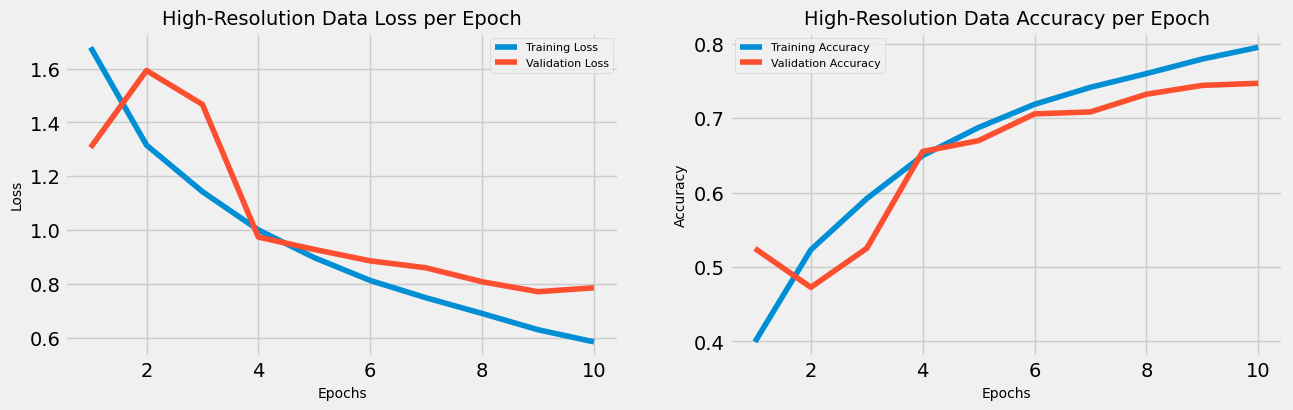

In [18]:
plot_metrics(history_high, "High-Resolution Data")

low resolution

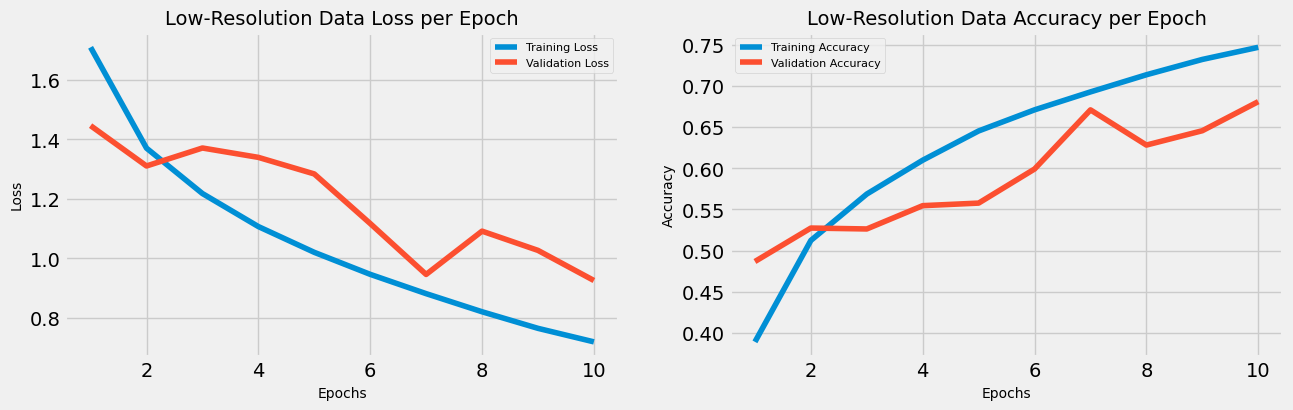

In [19]:
plot_metrics(history_low, "Low-Resolution Data")

# Step 8

confusion matrix

high resolution

In [20]:
y_pred_high= np.argmax(high_res_cnn_model.predict(x_test_high), axis= 1)
conf_matrix_high= confusion_matrix(y_test, y_pred_high)

282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


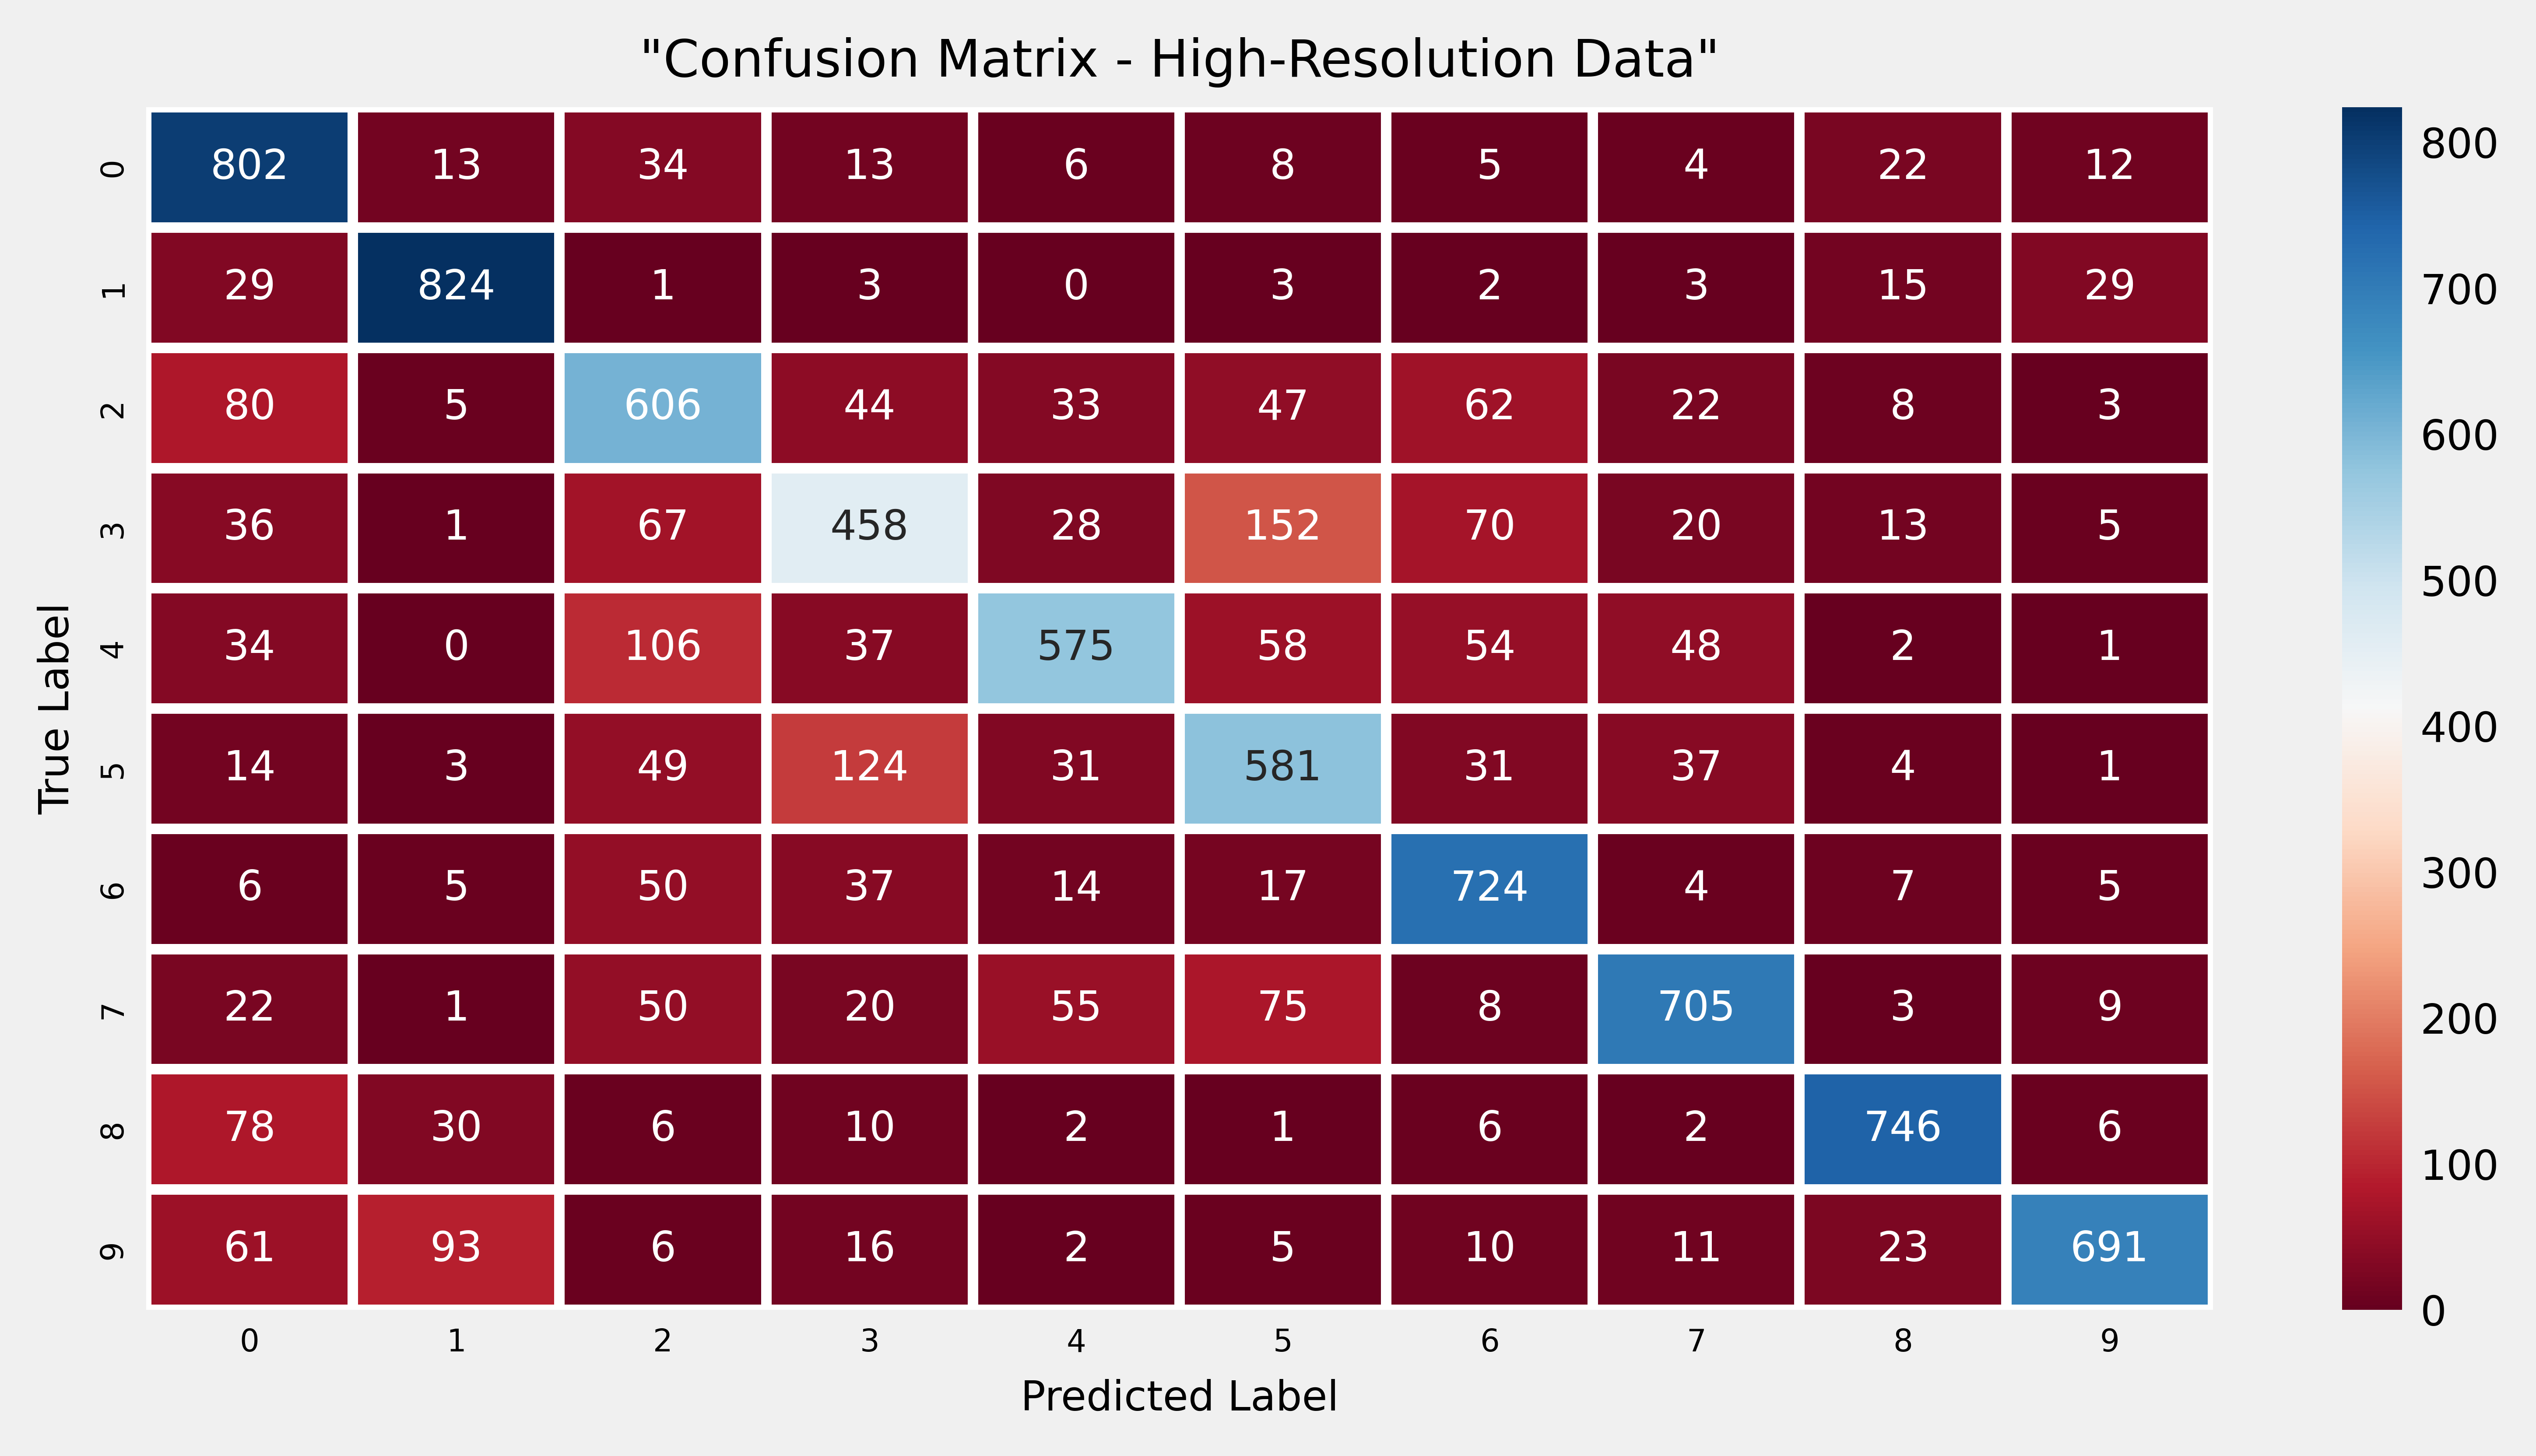

In [21]:
plt.style.use('fivethirtyeight')
fig, ax= plt.subplots(figsize= (8, 4), dpi= 848)
heatmap= sns.heatmap(conf_matrix_high, annot= True, annot_kws={"fontsize": 8}, fmt= 'd', linecolor= 'white', linewidths= 2, cmap= 'RdBu')
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize= 8)
ax.set_yticklabels(range(10), fontsize= 6)
ax.set_xticklabels(range(10), fontsize= 6, rotation= 0)
ax.set_xlabel("Predicted Label", fontsize= 8)
ax.set_ylabel("True Label", fontsize= 8)
ax.set_title('"Confusion Matrix - High-Resolution Data"', fontsize= 10);

low resolution

In [22]:
y_pred_low= np.argmax(low_res_cnn_model.predict(x_test_low), axis=1)
conf_matrix_low= confusion_matrix(y_test, y_pred_low)

282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


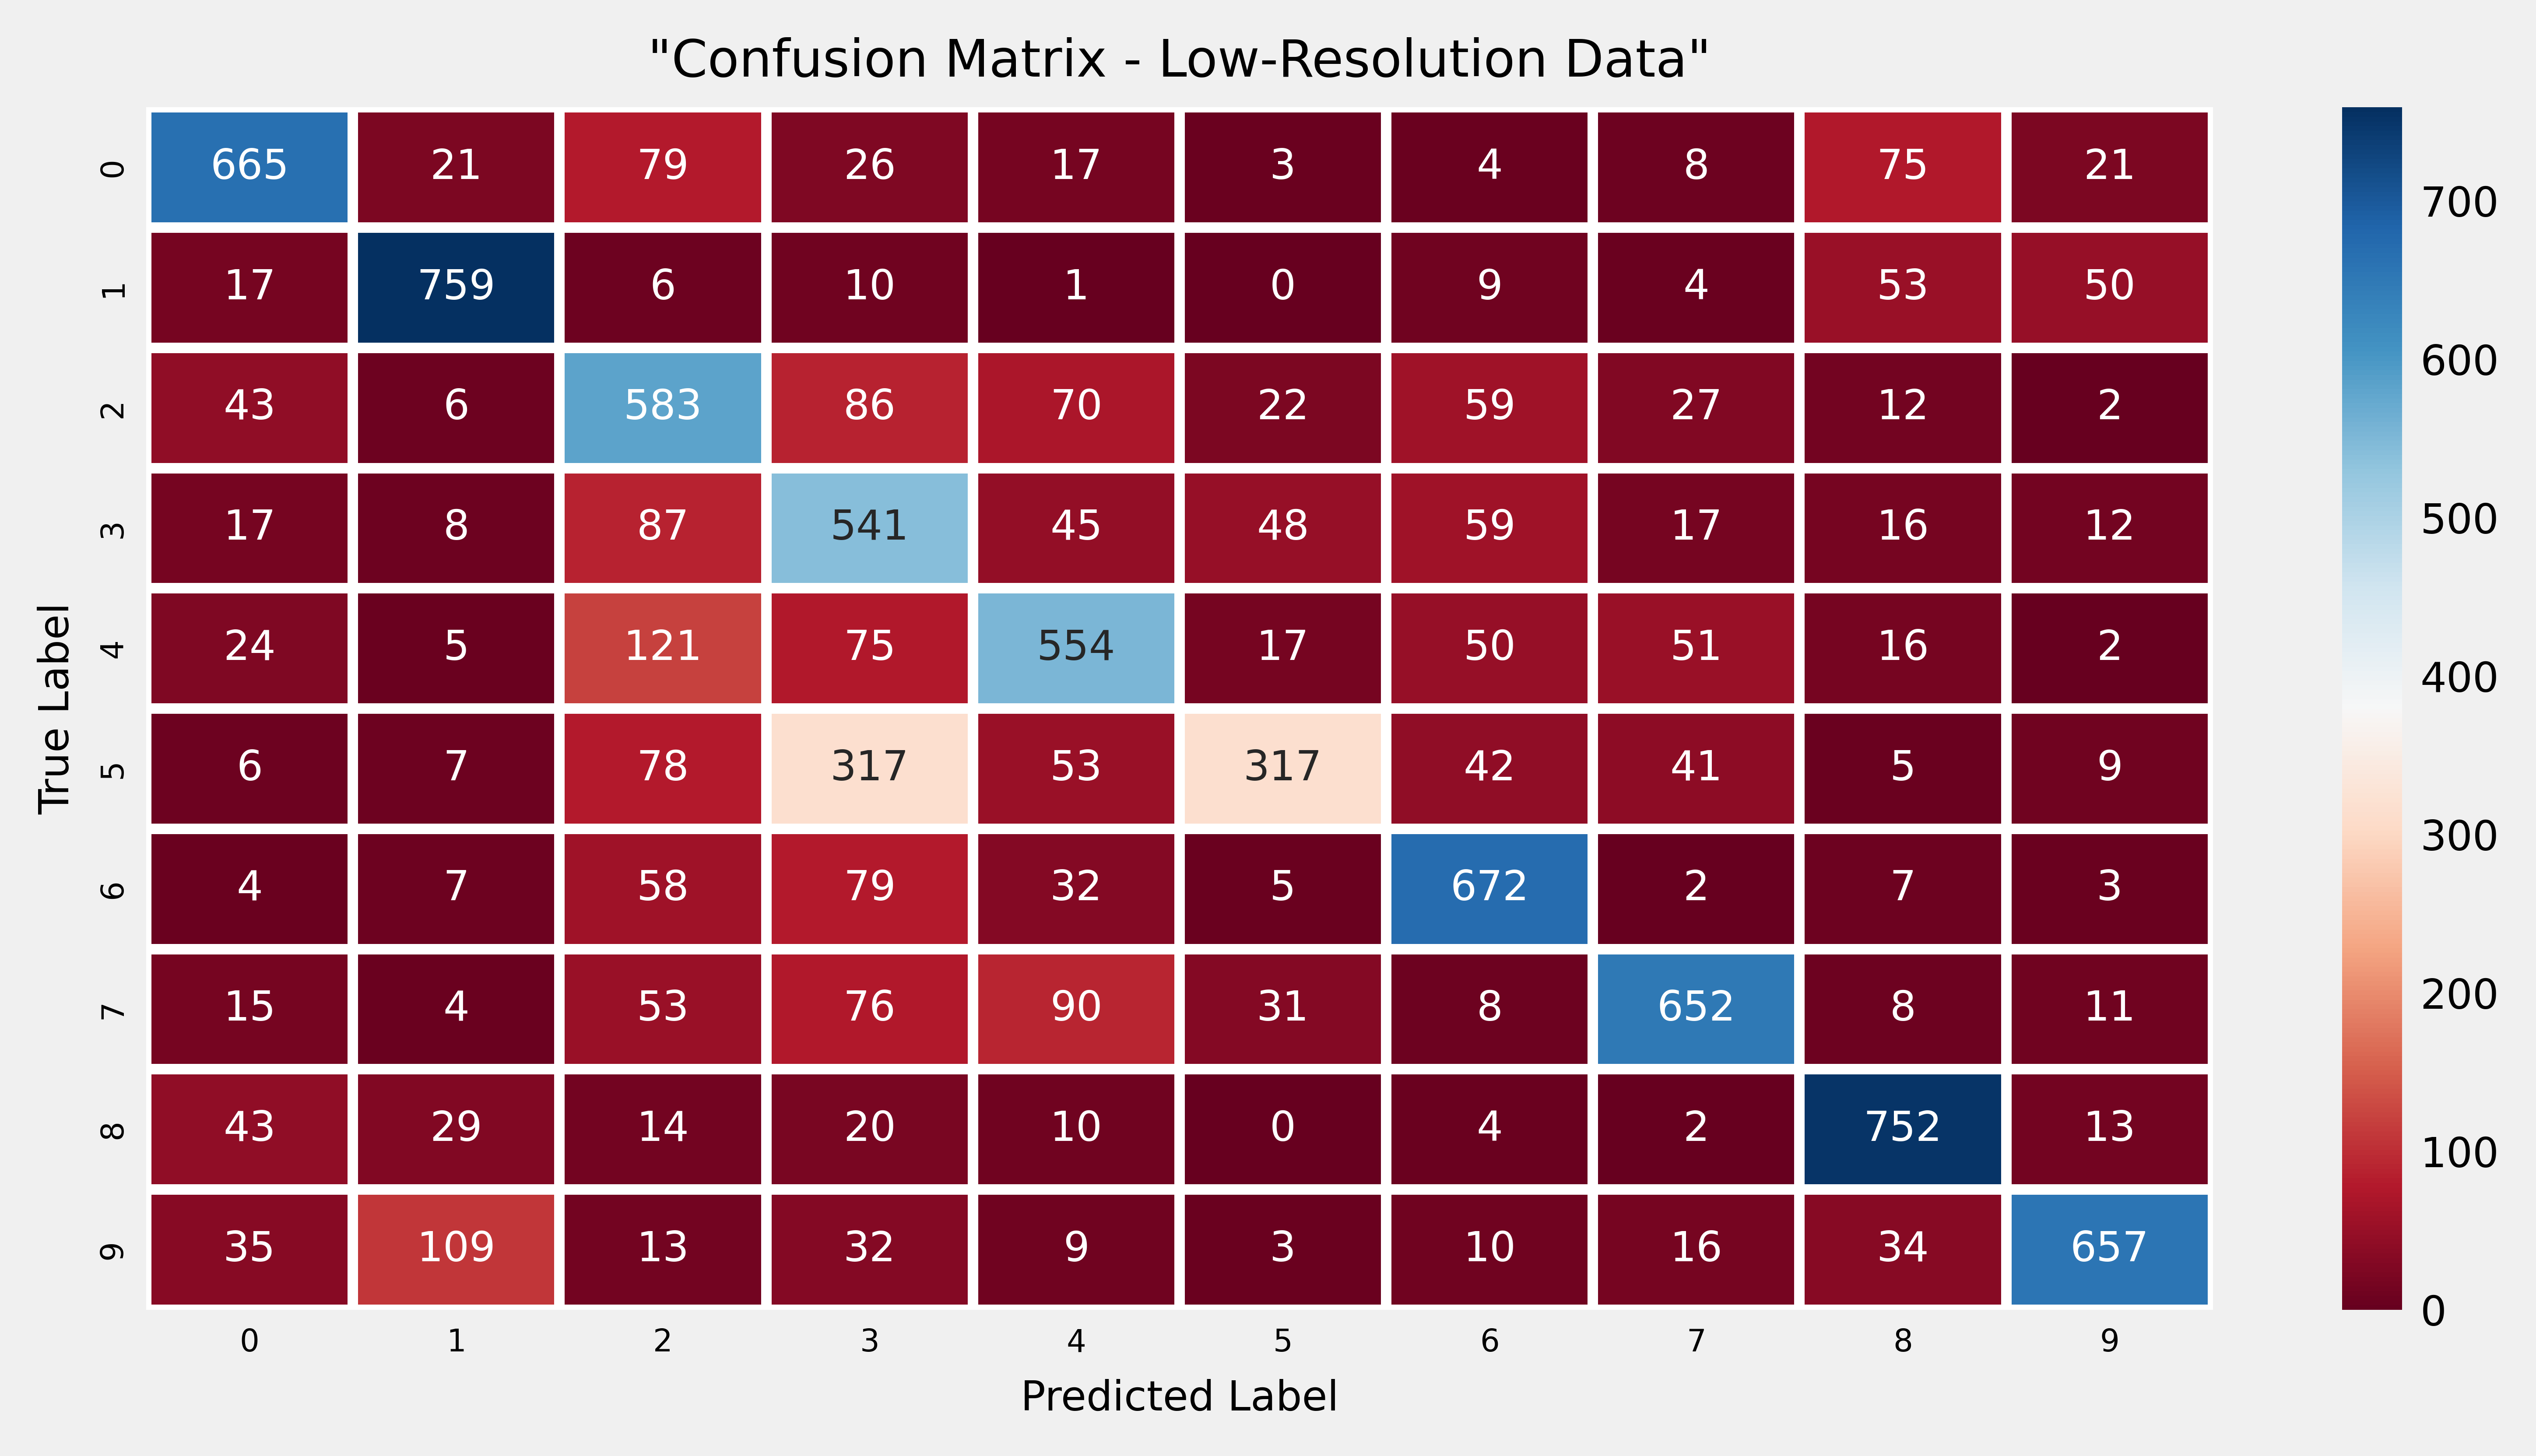

In [23]:
plt.style.use('fivethirtyeight')
fig, ax= plt.subplots(figsize= (8, 4), dpi= 848)
heatmap= sns.heatmap(conf_matrix_low, annot= True, annot_kws={"fontsize": 8}, fmt= 'd', linecolor= 'white', linewidths= 2, cmap= 'RdBu')
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize= 8)
ax.set_yticklabels(range(10), fontsize= 6)
ax.set_xticklabels(range(10), fontsize= 6, rotation= 0)
ax.set_xlabel("Predicted Label", fontsize= 8)
ax.set_ylabel("True Label", fontsize= 8)
ax.set_title('"Confusion Matrix - Low-Resolution Data"', fontsize= 10);

# Step 4 ... 8 for a general CNN model

creating the model

In [24]:
def create_general_cnn_model():
    model= models.Sequential([
        # first convolutional layer
        layers.Conv2D(32, (3, 3), activation= 'relu', padding= 'same', input_shape= (None, None, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # second convolutional layer
        layers.Conv2D(64, (3, 3), activation= 'relu', padding= 'same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # third convolutional layer
        layers.Conv2D(128, (3, 3), activation= 'relu', padding= 'same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # global average pooling instead of Flatten
        layers.GlobalAveragePooling2D(),

        # fully connected layers
        layers.Dense(128, activation= 'relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation= 'softmax')  # 10-class output
    ])
    return model

# "high resolution"

In [25]:
# create the model
general_high_res_cnn_model= create_general_cnn_model()

# compile the model
general_high_res_cnn_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001),  # optimizer and learning rate
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),     # loss function
    metrics=['accuracy']                                      # metrics
)

# model summary
general_high_res_cnn_model.summary()

f:\Quera\Qvenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, None, None, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, None, None, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, None, None, 64) │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,946 (437.29 KB)

 Trainable params: 111,498 (435.54 KB)

 Non-trainable params: 448 (1.75 KB)

training

In [26]:
print("Training on high-resolution data...")
history_high_general= general_high_res_cnn_model.fit(
    x_train_high, y_train,
    validation_data= (x_val_high, y_val),
    epochs= 10,
    batch_size= 64
)

print("\nEvaluating on high-resolution test data...")
test_loss_high_general, test_acc_high_general= general_high_res_cnn_model.evaluate(x_test_high, y_test)
print(f"Test Accuracy (High-Resolution): {test_acc_high_general:.4f}")

Training on high-resolution data...
Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 96s 135ms/step - accuracy: 0.3579 - loss: 1.7908 - val_accuracy: 0.3939 - val_loss: 1.8771
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 89s 136ms/step - accuracy: 0.5668 - loss: 1.2116 - val_accuracy: 0.4566 - val_loss: 1.4789
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 89s 136ms/step - accuracy: 0.6338 - loss: 1.0343 - val_accuracy: 0.6512 - val_loss: 0.9706
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 89s 135ms/step - accuracy: 0.6818 - loss: 0.9015 - val_accuracy: 0.6103 - val_loss: 1.1572
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 88s 135ms/step - accuracy: 0.7101 - loss: 0.8233 - val_accuracy: 0.5956 - val_loss: 1.1476
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 91s 139ms/step - accuracy: 0.7374 - loss: 0.7484 - val_accuracy: 0.6649 - val_loss: 1.0569
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 89s 136ms/step - accuracy: 0.7641 - loss: 0.6867 - val_accuracy: 0.6900 - val_loss: 0.9025
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 91s 138

visualization

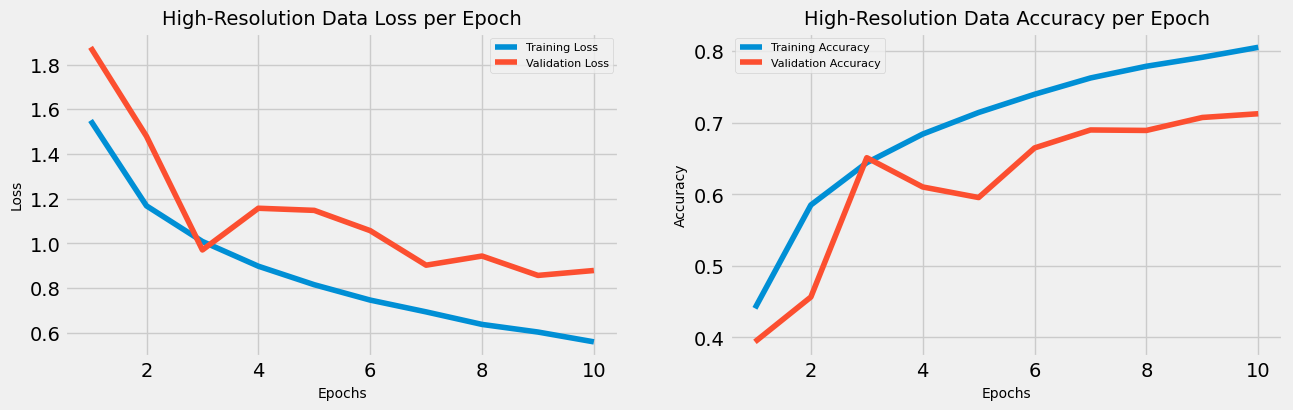

In [27]:
plot_metrics(history_high_general, "High-Resolution Data")

confusion matrix

In [28]:
y_pred_high_general= np.argmax(general_high_res_cnn_model.predict(x_test_high), axis= 1)
conf_matrix_high_general= confusion_matrix(y_test, y_pred_high_general)

282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


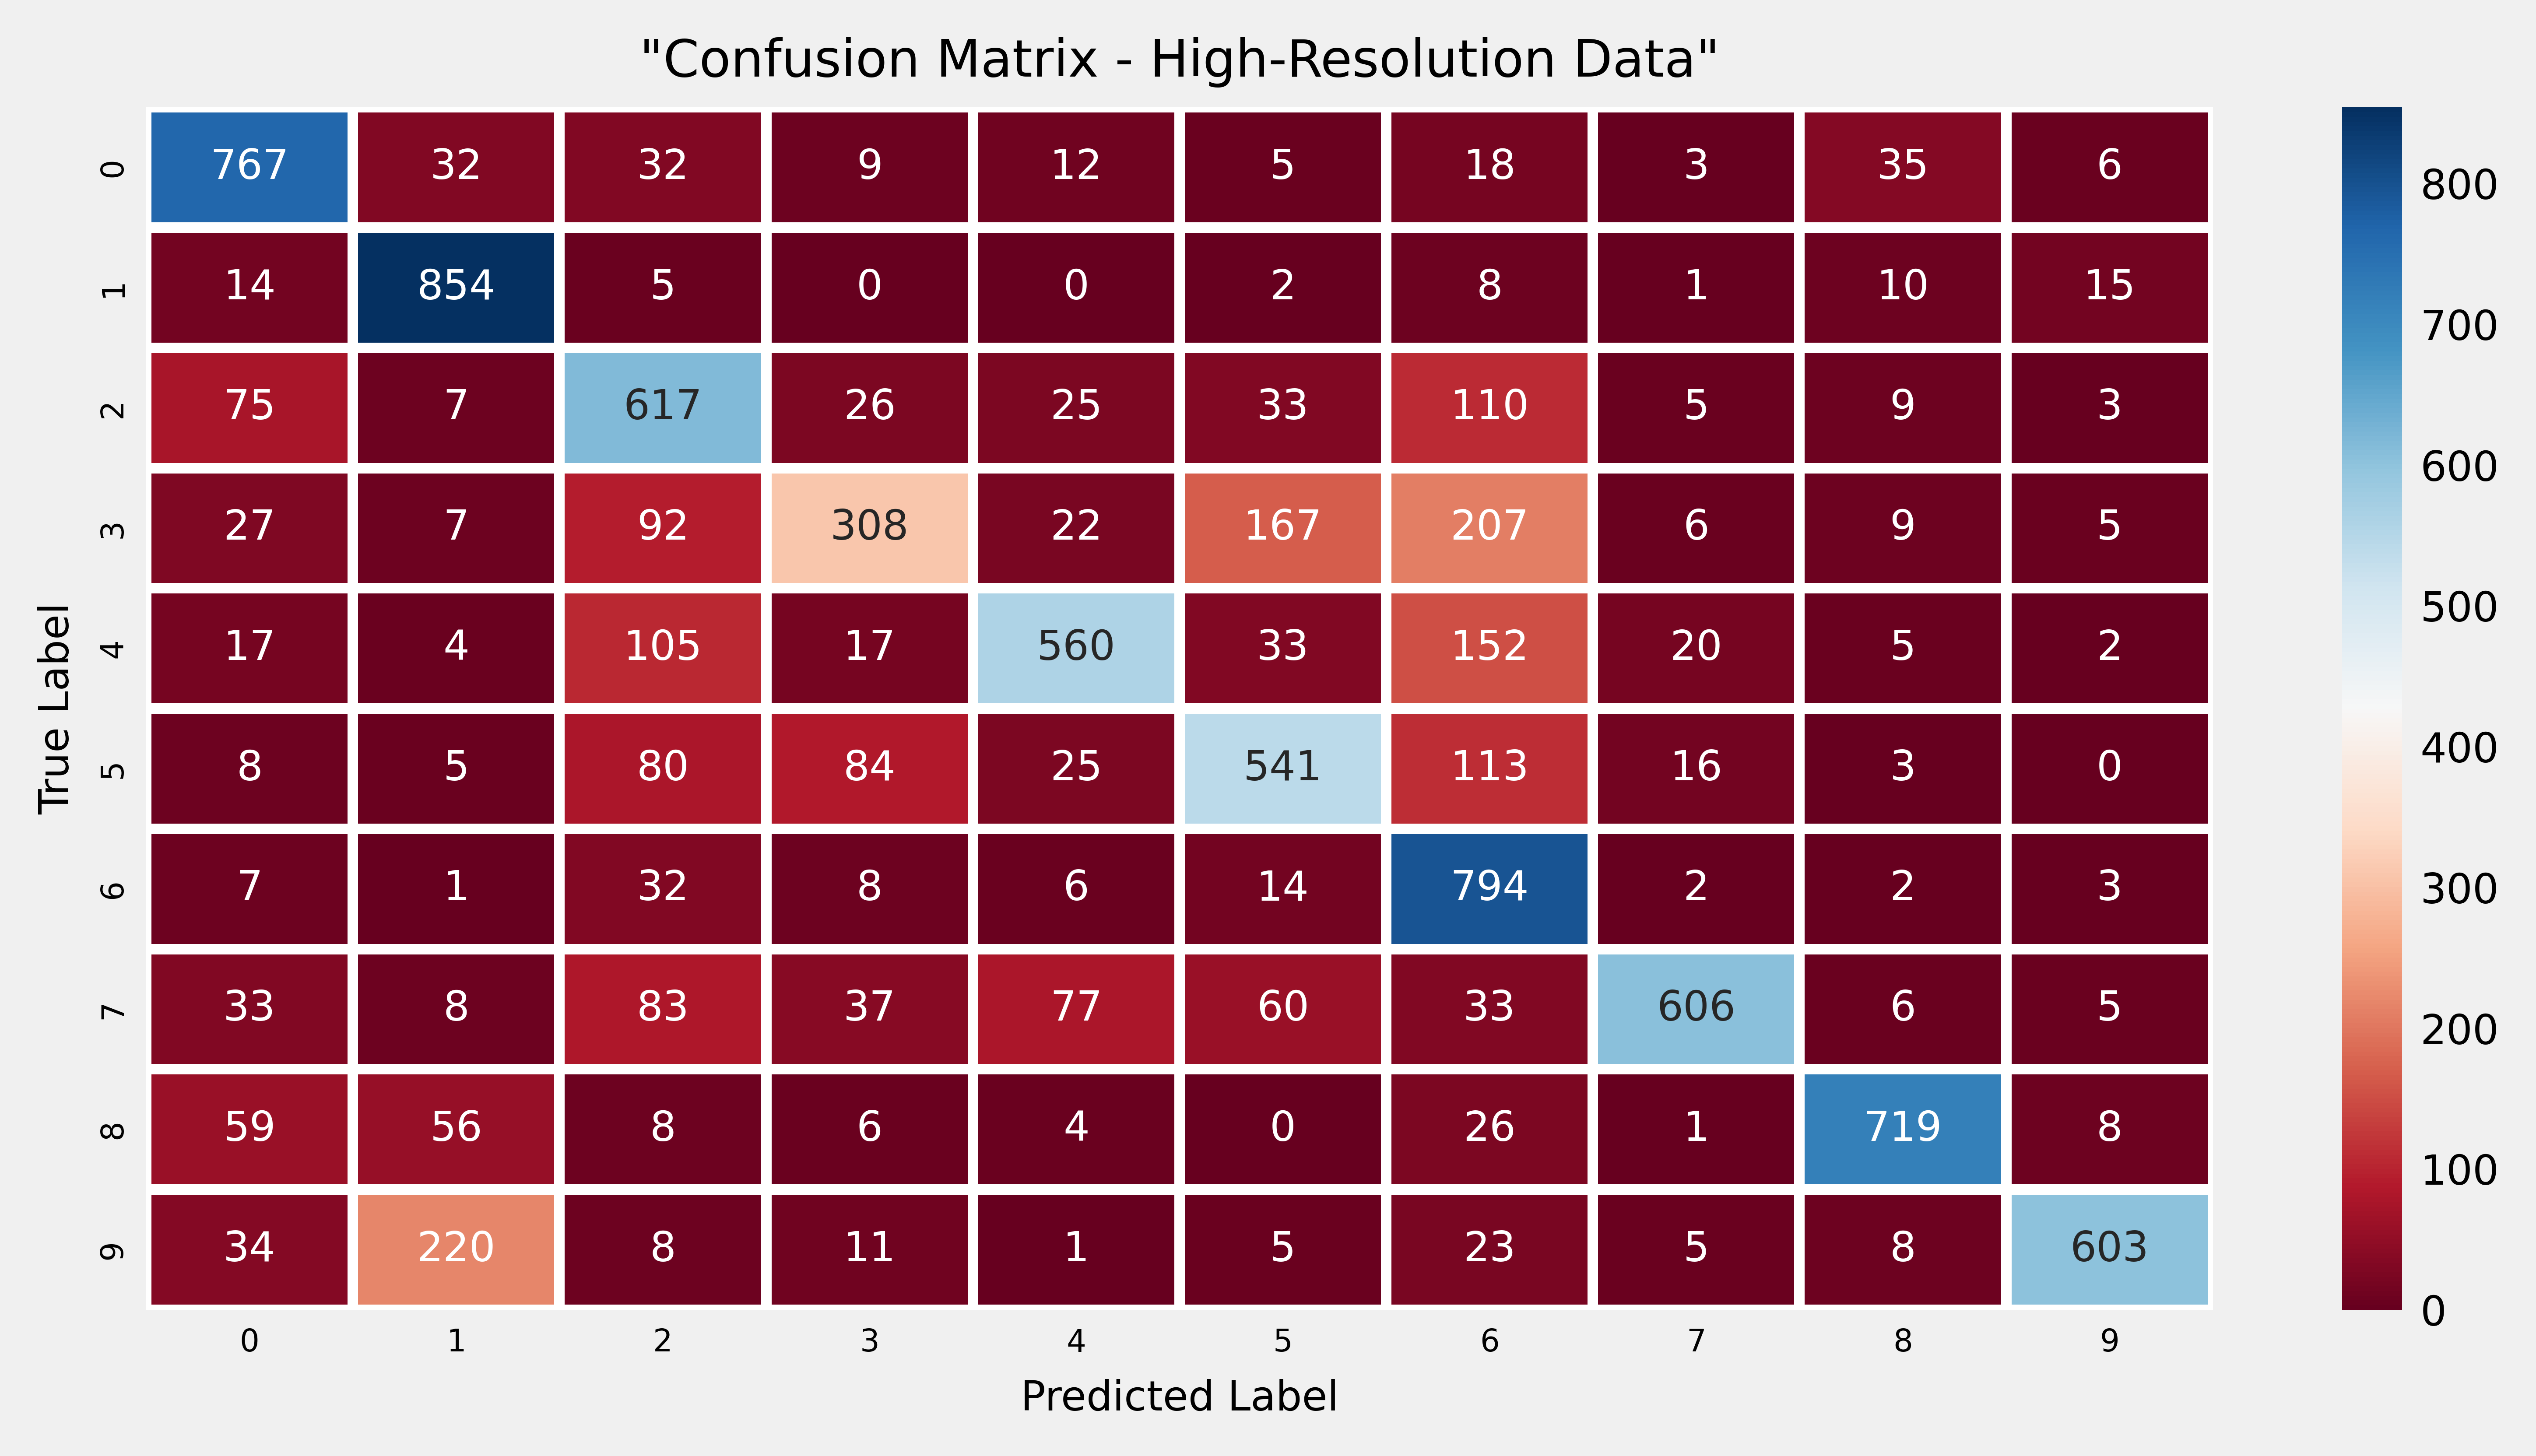

In [29]:
plt.style.use('fivethirtyeight')
fig, ax= plt.subplots(figsize= (8, 4), dpi= 848)
heatmap= sns.heatmap(conf_matrix_high_general, annot= True, annot_kws={"fontsize": 8}, fmt= 'd', linecolor= 'white', linewidths= 2, cmap= 'RdBu')
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize= 8)
ax.set_yticklabels(range(10), fontsize= 6)
ax.set_xticklabels(range(10), fontsize= 6, rotation= 0)
ax.set_xlabel("Predicted Label", fontsize= 8)
ax.set_ylabel("True Label", fontsize= 8)
ax.set_title('"Confusion Matrix - High-Resolution Data"', fontsize= 10);

# "low resolution"

In [30]:
# create the model
general_low_res_cnn_model= create_general_cnn_model()

# compile the model
general_low_res_cnn_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001),  # optimizer and learning rate
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),     # loss function
    metrics=['accuracy']                                      # metrics
)

# model summary
general_low_res_cnn_model.summary()

f:\Quera\Qvenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, None, None, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, None, None, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, None, None, 64) │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,946 (437.29 KB)

 Trainable params: 111,498 (435.54 KB)

 Non-trainable params: 448 (1.75 KB)

training

In [31]:
print("Training on low-resolution data...")
history_low_general= general_low_res_cnn_model.fit(
    x_train_low, y_train,
    validation_data= (x_val_low, y_val),
    epochs= 10,
    batch_size= 64
)

print("\nEvaluating on low-resolution test data...")
test_loss_low_general, test_acc_low_general= general_low_res_cnn_model.evaluate(x_test_low, y_test)
print(f"Test Accuracy (Low-Resolution): {test_acc_low_general:.4f}")

Training on low-resolution data...
Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.3456 - loss: 1.8340 - val_accuracy: 0.4928 - val_loss: 1.4242
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.5299 - loss: 1.3240 - val_accuracy: 0.4934 - val_loss: 1.4992
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.5940 - loss: 1.1515 - val_accuracy: 0.4618 - val_loss: 1.7438
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.6302 - loss: 1.0551 - val_accuracy: 0.5869 - val_loss: 1.1890
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.6634 - loss: 0.9651 - val_accuracy: 0.6149 - val_loss: 1.0980
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.6880 - loss: 0.8914 - val_accuracy: 0.6630 - val_loss: 0.9622
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.7078 - loss: 0.8339 - val_accuracy: 0.5816 - val_loss: 1.2501
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step -

visualization

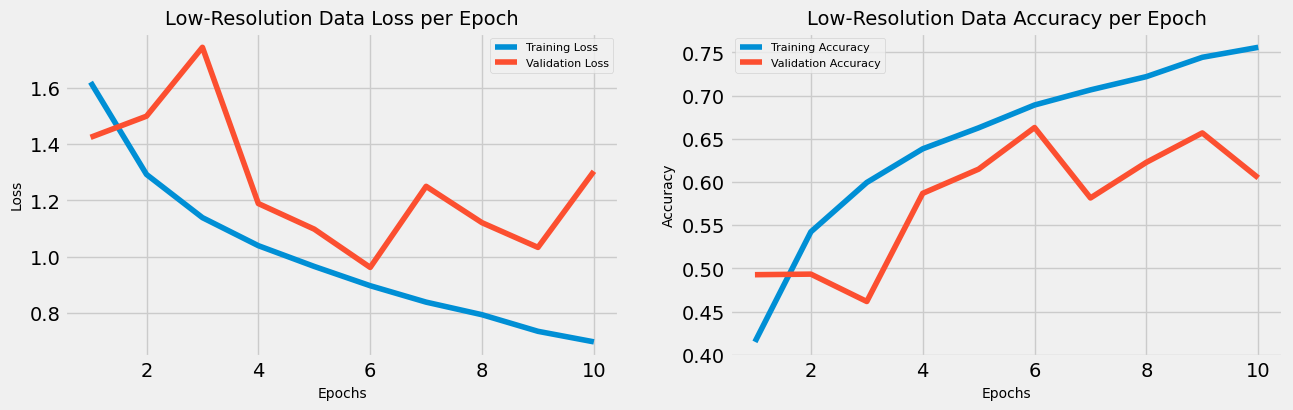

In [32]:
plot_metrics(history_low_general, "Low-Resolution Data")

confusion matrix

In [33]:
y_pred_low_general= np.argmax(general_low_res_cnn_model.predict(x_test_low), axis= 1)
conf_matrix_low_general= confusion_matrix(y_test, y_pred_high_general)

282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


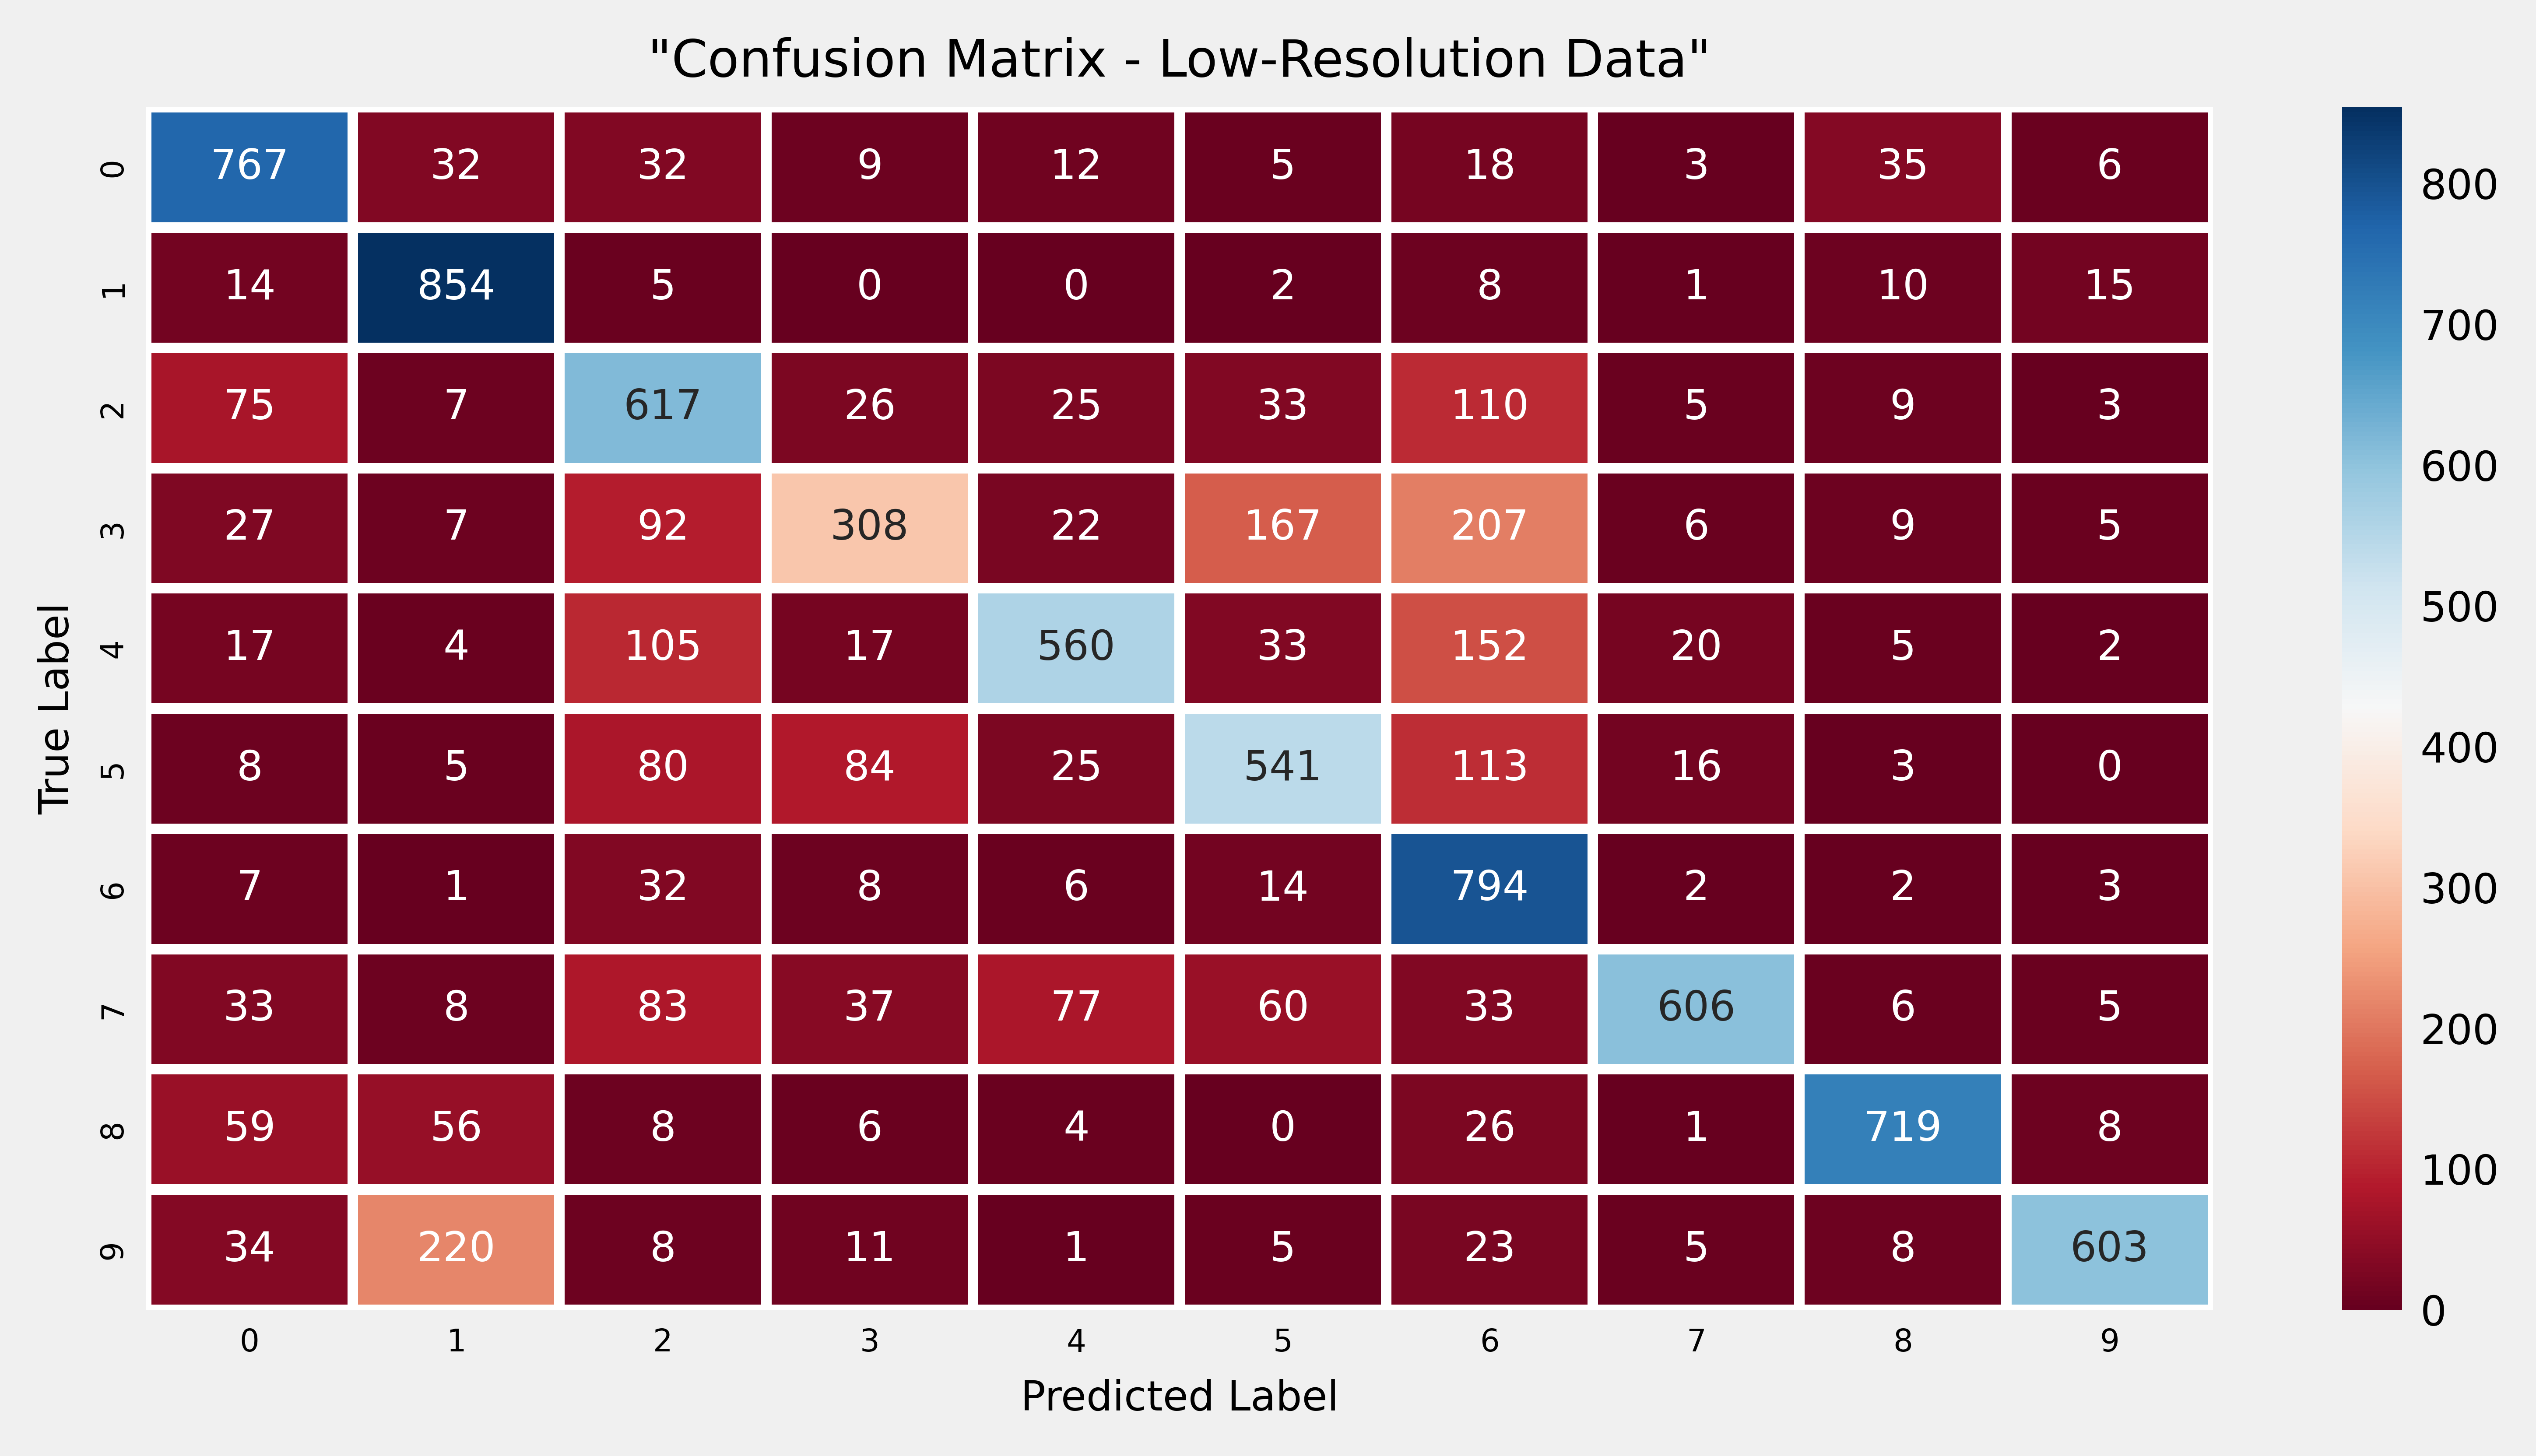

In [34]:
plt.style.use('fivethirtyeight')
fig, ax= plt.subplots(figsize= (8, 4), dpi= 848)
heatmap= sns.heatmap(conf_matrix_low_general, annot= True, annot_kws={"fontsize": 8}, fmt= 'd', linecolor= 'white', linewidths= 2, cmap= 'RdBu')
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize= 8)
ax.set_yticklabels(range(10), fontsize= 6)
ax.set_xticklabels(range(10), fontsize= 6, rotation= 0)
ax.set_xlabel("Predicted Label", fontsize= 8)
ax.set_ylabel("True Label", fontsize= 8)
ax.set_title('"Confusion Matrix - Low-Resolution Data"', fontsize= 10);

# Step 9

accuracy, precision, f1

a

In [35]:
y_pred_high_on_high= np.argmax(general_high_res_cnn_model.predict(x_test_high), axis= 1)
accuracy_high_on_high= accuracy_score(y_test, y_pred_high_on_high)
precision_high_on_high= precision_score(y_test, y_pred_high_on_high, average= 'weighted')
f1_high_on_high= f1_score(y_test, y_pred_high_on_high, average= 'weighted')

282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


b

In [36]:
y_pred_high_on_low= np.argmax(general_high_res_cnn_model.predict(x_test_low), axis= 1)
accuracy_high_on_low= accuracy_score(y_test, y_pred_high_on_low)
precision_high_on_low= precision_score(y_test, y_pred_high_on_low, average= 'weighted')
f1_high_on_low= f1_score(y_test, y_pred_high_on_low, average= 'weighted')

282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


c

In [37]:
y_pred_low_on_high= np.argmax(general_low_res_cnn_model.predict(x_test_high), axis= 1)
accuracy_low_on_high= accuracy_score(y_test, y_pred_low_on_high)
precision_low_on_high= precision_score(y_test, y_pred_low_on_high, average= 'weighted')
f1_low_on_high= f1_score(y_test, y_pred_low_on_high, average= 'weighted')

282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


d

In [38]:
y_pred_low_on_low= np.argmax(general_low_res_cnn_model.predict(x_test_low), axis= 1)
accuracy_low_on_low= accuracy_score(y_test, y_pred_low_on_low)
precision_low_on_low= precision_score(y_test, y_pred_low_on_low, average= 'weighted')
f1_low_on_low= f1_score(y_test, y_pred_low_on_low, average= 'weighted')

282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


results

In [39]:
results= {
    "High model on High test" : (accuracy_high_on_high, precision_high_on_high, f1_high_on_high),
    "High model on Low test" : (accuracy_high_on_low, precision_high_on_low, f1_high_on_low),
    "Low model on High test" : (accuracy_low_on_high, precision_low_on_high, f1_low_on_high),
    "Low model on Low test" : (accuracy_low_on_low, precision_low_on_low, f1_low_on_low)
}

for scenario, metrics in results.items():
    print(f"{scenario}:")
    print(f"  Accuracy: {metrics[0]:.4f}")
    print(f"  Precision: {metrics[1]:.4f}")
    print(f"  F1-Score: {metrics[2]:.4f}\n")

High model on High test:
  Accuracy: 0.7077
  Precision: 0.7328
  F1-Score: 0.7044

High model on Low test:
  Accuracy: 0.3989
  Precision: 0.4387
  F1-Score: 0.3844

Low model on High test:
  Accuracy: 0.3644
  Precision: 0.5508
  F1-Score: 0.2966

Low model on Low test:
  Accuracy: 0.6010
  Precision: 0.6667
  F1-Score: 0.5908

